# Import Packages

In [1]:
# keras module for building LSTM 
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras import preprocessing
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
from keras.utils import np_utils


# set seeds for reproducability
from numpy.random import seed
tf.random.set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Pre-Proccessing

## Extract headlines from all the three .csv files 

In [2]:
curr_dir = 'Articles/'
all_headlines = []
for filename in os.listdir(curr_dir):
    print(filename)
    if 'articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.title.values))

all_headlines = [h for h in all_headlines if type(h) == str]
len(all_headlines)

articles1.csv
articles2.csv
articles3.csv


142568

In [3]:
all_headlines[:10]

['House Republicans Fret About Winning Their Health Care Suit - The New York Times',
 'Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times',
 'Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times',
 'Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times',
 'Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times',
 'Sick With a Cold, Queen Elizabeth Misses New Year’s Service - The New York Times',
 'Taiwan’s President Accuses China of Renewed Intimidation - The New York Times',
 'After ‘The Biggest Loser,’ Their Bodies Fought to Regain Weight - The New York Times',
 'First, a Mixtape. Then a Romance. - The New York Times',
 'Calling on Angels While Enduring the Trials of Job - The New York Times']

## Cleaning the Data 

- Remove ' - The New York Times'
- Remove punctuations and turn into lowercase
- Ignore symbols

In [4]:
import re
def clean_text(txt):
    t = txt
    if 'The New York Times' in txt:
        t = txt.replace('The New York Times','')
    t = re.sub(r'[^\w\s]', '', t).lower()
    t = t.encode("utf8").decode("ascii",'ignore')
    return t 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['house republicans fret about winning their health care suit  ',
 'rift between officers and residents as killings persist in south bronx  ',
 'tyrus wong bambi artist thwarted by racial bias dies at 106  ',
 'among deaths in 2016 a heavy toll in pop music  ',
 'kim jongun says north korea is preparing to test longrange missile  ',
 'sick with a cold queen elizabeth misses new years service  ',
 'taiwans president accuses china of renewed intimidation  ',
 'after the biggest loser their bodies fought to regain weight  ',
 'first a mixtape then a romance  ',
 'calling on angels while enduring the trials of job  ']

In [5]:
corpus = corpus[:4500]
len(corpus)

4500

# Tokenization

In [6]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[56, 87],
 [56, 87, 2735],
 [56, 87, 2735, 72],
 [56, 87, 2735, 72, 1302],
 [56, 87, 2735, 72, 1302, 57],
 [56, 87, 2735, 72, 1302, 57, 63],
 [56, 87, 2735, 72, 1302, 57, 63, 157],
 [56, 87, 2735, 72, 1302, 57, 63, 157, 262],
 [1596, 321],
 [1596, 321, 385]]

# Padding the Sequences and obtain Variables

In [7]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = np_utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

# Create LSTM Model

In [8]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 10)            96200     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 9620)              971620    
                                                                 
Total params: 1,112,220
Trainable params: 1,112,220
Non-trainable params: 0
_________________________________________________________________


### Train the Model 

In [9]:
lstm = model.fit(predictors, label, epochs=60, verbose=1, batch_size=32)

Epoch 1/60
1218/1218 [==============================] - 32s 19ms/step - loss: 7.9876
Epoch 2/60
1218/1218 [==============================] - 22s 18ms/step - loss: 7.5461
Epoch 3/60
1218/1218 [==============================] - 23s 19ms/step - loss: 7.3810
Epoch 4/60
1218/1218 [==============================] - 23s 19ms/step - loss: 7.2108
Epoch 5/60
1218/1218 [==============================] - 22s 18ms/step - loss: 7.0194
Epoch 6/60
1218/1218 [==============================] - 23s 19ms/step - loss: 6.8019
Epoch 7/60
1218/1218 [==============================] - 23s 19ms/step - loss: 6.5606
Epoch 8/60
1218/1218 [==============================] - 23s 19ms/step - loss: 6.3153
Epoch 9/60
1218/1218 [==============================] - 23s 19ms/step - loss: 6.0749
Epoch 10/60
1218/1218 [==============================] - 23s 19ms/step - loss: 5.8470
Epoch 11/60
1218/1218 [==============================] - 23s 19ms/step - loss: 5.6301
Epoch 12/60
1218/1218 [==============================] - 23s 19

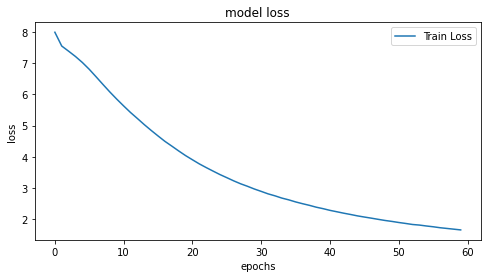

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(lstm.history['loss'], label='Train Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

# Predictions

In [11]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [23]:
print(generate_text("Europe", 7, model, max_sequence_len))
print(generate_text("donald trump", 6, model, max_sequence_len))
print(generate_text("elon musk", 9, model, max_sequence_len))
print(generate_text("Sweden", 6, model, max_sequence_len))

1/1 [==============================] - 0s 37ms/step
Europe Combats A New Foe Of Political Stability
1/1 [==============================] - 0s 36ms/step
Donald Trump And Hillary Clinton During The Debate
1/1 [==============================] - 0s 40ms/step
Elon Musk Says Pending Tesla Updates Could Have Prevented Fatal Crash
1/1 [==============================] - 0s 50ms/step
Sweden To Close Your Thursday Evening Briefing
